In [57]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'algerian-forest-fires-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2571288%2F4376061%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240730%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240730T234635Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da32938293b01890f92b5111913502e412b598587a3975191aec2ecbbbc96d1c1e746127a096e502cdf854077d03f5f4b0a97ba88be850dfcb338f28d127727d2364ad1e308bbd1788c46ab3e90e08af5bf8b9617e9d3f994af0fa471969171c5e9d826348f99cd7fae7d1df033a6abc1bbdf5bb744f59c977439cd001ab1b24aed05767e3f2acbb7fb9a681b17fdfc4c2605ad5ee591af31981e97c69433ffe6125d5216be6c30f1826a890e374693893c00851aeb67c88102687edaa580bb7067d6d9f8d7a85a8ad70962757e49e76a34d6dec0775fb0df7ba91216961c6a4704b5055ca0457b68fad0083553c7dc8f7d910d12da16054591d63470e580511b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4873 bytes downloaded
Downloaded and uncompressed: algerian-forest-fires-dataset
Data source import complete.


## Let's start our analysis

### Import common modules

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### OSEMN - 1. Obtain

In [59]:
df = pd.read_csv("/kaggle/input/algerian-forest-fires-dataset/Algerian_forest_fires_dataset.csv")

### OSEMN - 2. Scrub

In [60]:
df.shape

(247, 14)

In [61]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,1,6,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
4,5,6,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire


In [62]:
df["month"].unique()

array(['6', '7', '8', '9', nan, 'month'], dtype=object)

In [63]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  '],
      dtype='object')

In [64]:
df.describe().T

,count,unique,top,freq
day,246,33,1,8
month,245,5,7,62
year,245,2,2012,244
Temperature,245,20,35,29
RH,245,63,64,10
Ws,245,19,14,43
Rain,245,40,0,133
FFMC,245,174,88.9,8
DMC,245,167,7.9,5
DC,245,199,8,5


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   day          246 non-null    object
 1   month        245 non-null    object
 2   year         245 non-null    object
 3   Temperature  245 non-null    object
 4    RH          245 non-null    object
 5    Ws          245 non-null    object
 6   Rain         245 non-null    object
 7   FFMC         245 non-null    object
 8   DMC          245 non-null    object
 9   DC           245 non-null    object
 10  ISI          245 non-null    object
 11  BUI          245 non-null    object
 12  FWI          245 non-null    object
 13  Classes      244 non-null    object
dtypes: object(14)
memory usage: 27.1+ KB


In [66]:
## missing values
df[df.isnull().any(axis=1)]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
168,14,7,2012,37,37,18,0.2,88.9,12.9,14.6 9,12.5,10.4,fire,NaN


The dataset is converted into two sets based on Region from 122th index, we can make a new column based on the Region

1 : "Bejaia Region Dataset"

2 : "Sidi-Bel Abbes Region Dataset"

Add new column with region

In [67]:
df.iloc[120:127]

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
120,29,9,2012,26,80,16,1.8,47.4,2.9,7.7,0.3,3,0.1,not fire
121,30,9,2012,25,78,14,1.4,45,1.9,7.5,0.2,2.4,0.1,not fire
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,Sidi-Bel Abbes Region Dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
125,1,6,2012,32,71,12,0.7,57.1,2.5,8.2,0.6,2.8,0.2,not fire
126,2,6,2012,30,73,13,4,55.7,2.7,7.8,0.6,2.9,0.2,not fire


In [68]:
df.loc[:122, "Region"] = 0
df.loc[122:, "Region"] = 1

In [69]:
df[["Region"]] = df[["Region"]].astype(int)

In [70]:
df.isnull().sum()

,0
day,1
month,2
year,2
Temperature,2
RH,2
Ws,2
Rain,2
FFMC,2
DMC,2
DC,2


In [71]:
## Removing the null values
df = df.dropna().reset_index(drop=True)

In [72]:
##remove the 122nd row
df = df.drop(122).reset_index(drop=True)

In [73]:
df.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire,0
4,5,6,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire,0


In [74]:
df.columns

Index(['day', 'month', 'year', 'Temperature', ' RH', ' Ws', 'Rain ', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes  ', 'Region'],
      dtype='object')

In [75]:
def clean_column_names(df):
    """
    Function to convert all column names in a DataFrame to lowercase and stripped of leading/trailing spaces.

    Args:
    df (pd.DataFrame): The DataFrame whose column names need to be cleaned.

    Returns:
    pd.DataFrame: DataFrame with cleaned column names.
    """
    df.columns = [col.strip().lower() for col in df.columns]
    return df

df = clean_column_names(df)

In [76]:
df[["month", "day", "year", "temperature", "rh", "ws"]] = df[
    ["month", "day", "year", "temperature", "rh", "ws"]
].astype(int)

In [77]:
objects = [features for features in df.columns if df[features].dtypes == "O"]
print(objects)
for i in objects:
    if i != "classes":
        df[i] = df[i].astype(float)

['rain', 'ffmc', 'dmc', 'dc', 'isi', 'bui', 'fwi', 'classes']


In [78]:
## categories in classes
df["classes"].value_counts()

,count
classes,
fire,131
not fire,101
fire,4
fire,2
not fire,2
not fire,1
not fire,1
not fire,1


In [79]:
## Encoding
df["classes"] = np.where(df["classes"].str.contains("not fire"), 0, 1)

In [80]:
## categories in classes
df["classes"].value_counts()

,count
classes,
1,137
0,106


In [81]:
df.sample(10)

,day,month,year,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
26,27,6,2012,34,53,18,0.0,89.0,21.6,80.3,9.2,25.8,15.0,1,0
193,12,8,2012,39,21,17,0.4,93.0,18.4,41.5,15.5,18.4,18.8,1,1
145,24,6,2012,35,68,16,0.0,85.3,10.0,17.0,4.9,9.9,5.3,1,1
63,3,8,2012,35,63,14,0.3,76.6,5.7,10.0,1.7,5.5,0.8,0,0
163,12,7,2012,36,44,13,0.0,90.1,12.6,19.4,8.3,12.5,9.6,1,1
200,19,8,2012,35,66,15,0.1,82.7,32.7,96.8,3.3,35.5,7.7,1,1
92,1,9,2012,25,76,17,7.2,46.0,1.3,7.5,0.2,1.8,0.1,0,0
23,24,6,2012,32,66,17,0.0,85.9,11.2,55.8,5.6,14.9,7.5,1,0
213,1,9,2012,29,86,16,0.0,37.9,0.9,8.2,0.1,1.4,0.0,0,1
67,7,8,2012,32,69,16,0.0,86.5,15.5,48.6,5.5,17.2,8.0,1,0


In [82]:
# drop month,day and yyear
df.drop(["day", "month", "year"], axis=1, inplace=True)

In [83]:
# independent and dependent features
X=df.drop('fwi',axis=1)
y=df['fwi']

In [84]:
X.head()

,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,classes,region
0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0,0
1,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0,0
2,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0,0
3,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0,0
4,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0,0


In [85]:
y

,fwi
0,0.5
1,0.4
2,0.1
3,0.0
4,0.5
5,2.5
6,7.2
7,7.1
8,0.3
9,0.9


In [86]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [87]:
X_train.shape,X_test.shape

((182, 11), (61, 11))

## Feature Selection based on correlation

In [88]:
# Feature Selection based on correlation
df.corr()

,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,fwi,classes,region
temperature,1.000000,-0.651400,-0.284510,-0.326492,0.676568,0.485687,0.376284,0.603871,0.459789,0.566670,0.516015,0.269555
rh,-0.651400,1.000000,0.244048,0.222356,-0.644873,-0.408519,-0.226941,-0.686667,-0.353841,-0.580957,-0.432161,-0.402682
ws,-0.284510,0.244048,1.000000,0.171506,-0.166548,-0.000721,0.079135,0.008532,0.031438,0.032368,-0.069964,-0.181160
rain,-0.326492,0.222356,0.171506,1.000000,-0.543906,-0.288773,-0.298023,-0.347484,-0.299852,-0.324422,-0.379097,-0.040013
ffmc,0.676568,-0.644873,-0.166548,-0.543906,1.000000,0.603608,0.507397,0.740007,0.592011,0.691132,0.769492,0.222241
dmc,0.485687,-0.408519,-0.000721,-0.288773,0.603608,1.000000,0.875925,0.680454,0.982248,0.875864,0.585658,0.192089
dc,0.376284,-0.226941,0.079135,-0.298023,0.507397,0.875925,1.000000,0.508643,0.941988,0.739521,0.511123,-0.078734
isi,0.603871,-0.686667,0.008532,-0.347484,0.740007,0.680454,0.508643,1.000000,0.644093,0.922895,0.735197,0.263197
bui,0.459789,-0.353841,0.031438,-0.299852,0.592011,0.982248,0.941988,0.644093,1.000000,0.857973,0.586639,0.089408
fwi,0.566670,-0.580957,0.032368,-0.324422,0.691132,0.875864,0.739521,0.922895,0.857973,1.000000,0.719216,0.197102


In [89]:
corr = X_train.corr()
corr

,temperature,rh,ws,rain,ffmc,dmc,dc,isi,bui,classes,region
temperature,1.000000,-0.656095,-0.305977,-0.317512,0.694768,0.498173,0.390684,0.629848,0.473609,0.542141,0.254549
rh,-0.656095,1.000000,0.225736,0.241656,-0.653023,-0.414601,-0.236078,-0.717804,-0.362317,-0.456876,-0.394665
ws,-0.305977,0.225736,1.000000,0.251932,-0.190076,0.000379,0.096576,-0.023558,0.035633,-0.082570,-0.199969
rain,-0.317512,0.241656,0.251932,1.000000,-0.545491,-0.289754,-0.302341,-0.345707,-0.300964,-0.369357,-0.059022
ffmc,0.694768,-0.653023,-0.190076,-0.545491,1.000000,0.620807,0.524101,0.750799,0.607210,0.781259,0.249514
dmc,0.498173,-0.414601,0.000379,-0.289754,0.620807,1.000000,0.868647,0.685656,0.983175,0.617273,0.212582
dc,0.390684,-0.236078,0.096576,-0.302341,0.524101,0.868647,1.000000,0.513701,0.942414,0.543581,-0.060838
isi,0.629848,-0.717804,-0.023558,-0.345707,0.750799,0.685656,0.513701,1.000000,0.643818,0.742977,0.296441
bui,0.473609,-0.362317,0.035633,-0.300964,0.607210,0.983175,0.942414,0.643818,1.000000,0.612239,0.114897
classes,0.542141,-0.456876,-0.082570,-0.369357,0.781259,0.617273,0.543581,0.742977,0.612239,1.000000,0.188837


<Axes: >

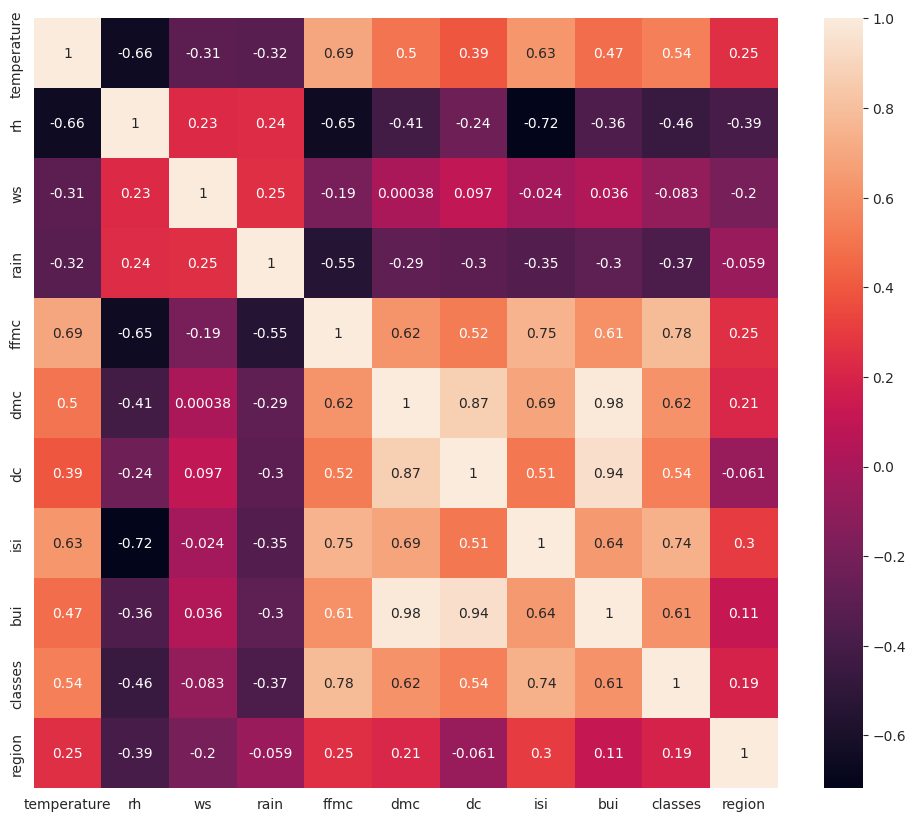

In [90]:
# Visualiza correlation and check for multicollinearity
plt.figure(figsize=(12,10))
sns.heatmap(corr,annot=True)

In [91]:
# This function helps in identifying and potentially removing features that are highly correlated,
# thereby reducing multicollinearity, which can affect the performance of certain types of models.
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [92]:
## threshold--Domain expertise
corr_features=correlation(X_train, 0.85)

In [93]:
corr_features

{'bui', 'dc'}

In [94]:
## drop features when correlation is more than 0.85
X_train.drop(corr_features,axis=1,inplace=True)
X_test.drop(corr_features,axis=1,inplace=True)
X_train.shape,X_test.shape

((182, 9), (61, 9))

In [95]:
# import and use StandardScaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [96]:
X_train_scaled

array([[-0.84284248,  0.78307967,  1.29972026, ..., -0.62963326,
        -1.10431526, -0.98907071],
       [-0.30175842,  0.64950844, -0.59874754, ..., -0.93058524,
        -1.10431526,  1.01105006],
       [ 2.13311985, -2.08870172, -0.21905398, ...,  2.7271388 ,
         0.90553851,  1.01105006],
       ...,
       [-1.9250106 ,  0.9166509 ,  0.54033314, ..., -1.06948615,
        -1.10431526, -0.98907071],
       [ 0.50986767, -0.21870454,  0.16063958, ...,  0.5973248 ,
         0.90553851,  1.01105006],
       [-0.57230045,  0.98343651,  2.05910739, ..., -0.86113478,
        -1.10431526, -0.98907071]])

## Elasticnet Regression

In [98]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
elastic=ElasticNet()
elastic.fit(X_train_scaled,y_train)
y_pred=elastic.predict(X_test_scaled)
elastic_mae_plain=mean_absolute_error(y_test,y_pred)
elastic_score_plain=r2_score(y_test,y_pred)
print("Mean absolute error: ", elastic_mae_plain)
print("R2 Score: ", elastic_score_plain)

Mean absolute error:  1.8822353634896005
R2 Score:  0.8753460589519703


Best parameters:  {'alpha': 0.049515006694731314, 'l1_ratio': 0.631578947368421}
Mean absolute error:  0.6563636385594531
R2 Score:  0.9813796320680215


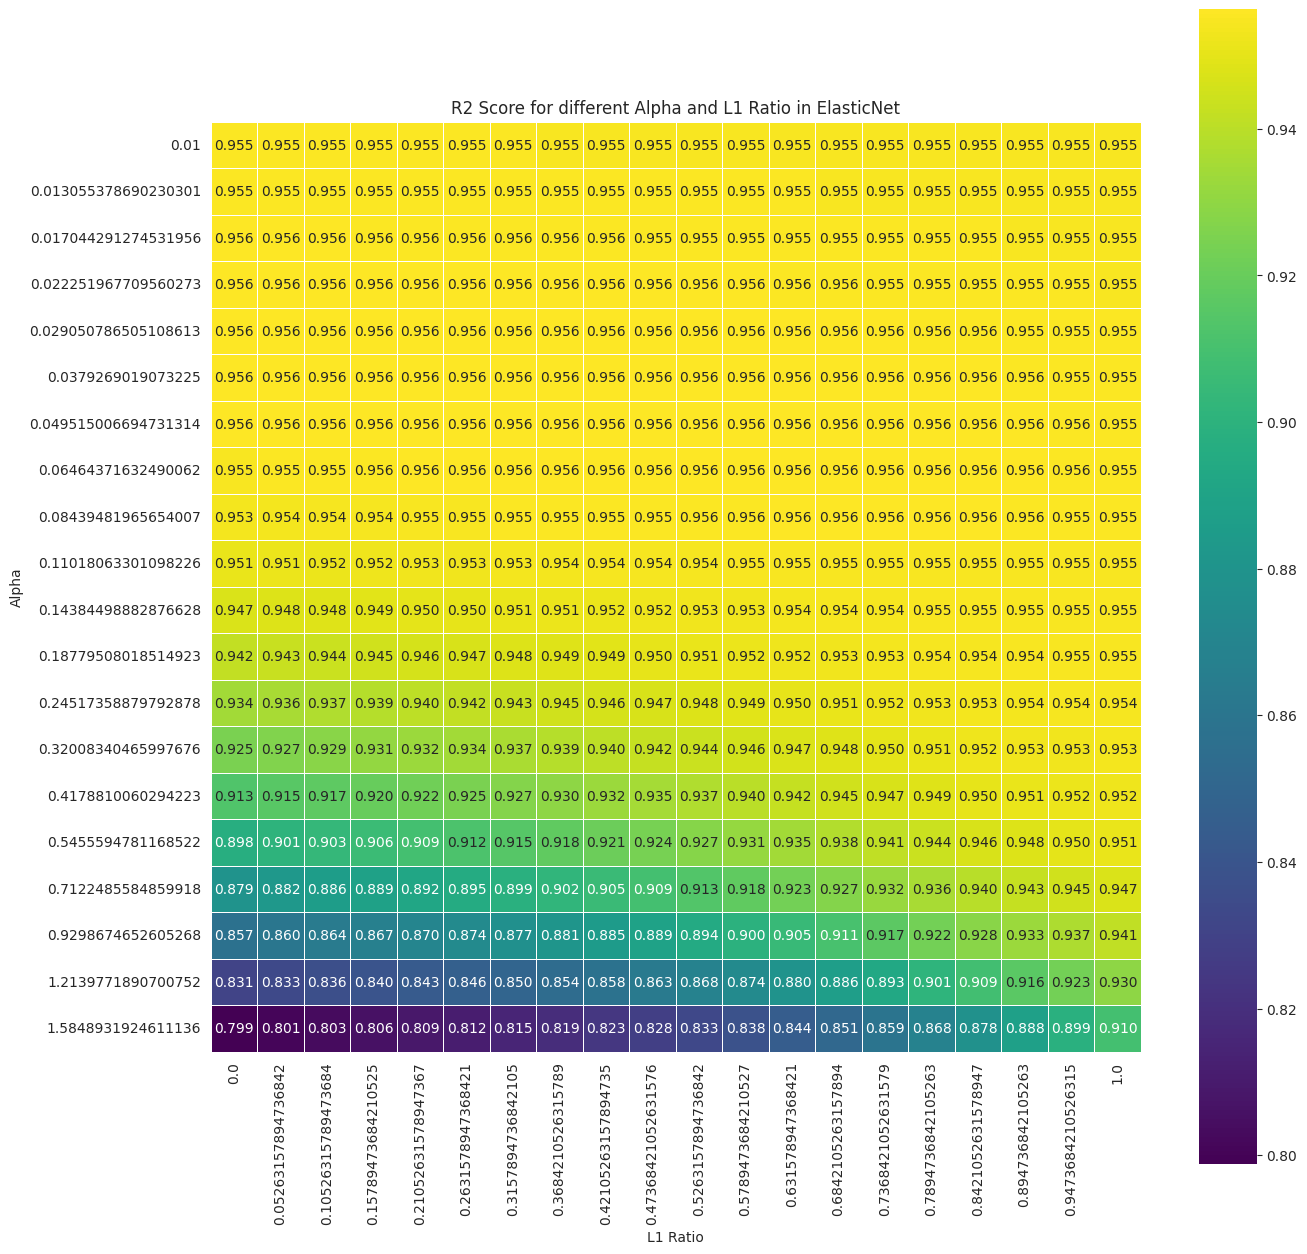

In [99]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")


# Set up Grid Search with Cross-Validation for ElasticNet
alpha_range = np.logspace(-2, 0.2, 20)  # Range for alpha
l1_ratio_range = np.linspace(0, 1, 20)  # Range for l1_ratio
param_grid = {"alpha": alpha_range, "l1_ratio": l1_ratio_range}
grid = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring="r2")

# Fit the Grid Search model
grid.fit(X_train_scaled, y_train)

# Find the best parameters
print("Best parameters: ", grid.best_params_)

# Re-fit the ElasticNet model with the best parameters
best_elastic = ElasticNet(
    alpha=grid.best_params_["alpha"], l1_ratio=grid.best_params_["l1_ratio"]
)
best_elastic.fit(X_train_scaled, y_train)

# Make predictions and evaluate the model
y_pred = best_elastic.predict(X_test_scaled)
elastic_mae = mean_absolute_error(y_test, y_pred)
elastic_score = r2_score(y_test, y_pred)
print("Mean absolute error: ", elastic_mae)
print("R2 Score: ", elastic_score)

# Extracting results for visualization
results = pd.DataFrame(grid.cv_results_)
scores_matrix = results.pivot(
    index="param_alpha", columns="param_l1_ratio", values="mean_test_score"
)

# Plotting the results
plt.figure(figsize=(15, 15))
sns.heatmap(
    scores_matrix, annot=True, fmt=".3f", linewidths=0.5, cmap="viridis", square=True
)
plt.xlabel("L1 Ratio")
plt.ylabel("Alpha")
plt.title("R2 Score for different Alpha and L1 Ratio in ElasticNet")
plt.show()